In [56]:
using CancerSeqSim, Distributions, Gadfly

In [35]:
type cancercell
    mutations::Array{Int64,1}
    fitness::Int64
end

In [40]:
function newmutations(cancercell, mutID)

    numbermutations= 1
    cancercell.mutations = append!(cancercell.mutations, mutID:mutID+numbermutations-1)
    mutID = mutID + numbermutations
    
    neoep = rand()<0.8
    if neoep
        cancercell.fitness = 0
    end

    return cancercell, mutID, neoep
end

function copycell(cancercellold::cancercell)
  newcancercell::cancercell = cancercell(copy(cancercellold.mutations), copy(cancercellold.fitness))
end

function tumourgrow_birthdeath_neoep(b0, d0, b_, d_, Nmax)


    #Rmax starts with b + d and changes once a fitter mutant is introduced, this ensures that
    # b and d have correct units
    Rmax = b0+d_

    #initialize arrays and parameters
    mutID = 1
    cells = cancercell[]
    push!(cells,cancercell([],1))
    cells[1],mutID,neoep = newmutations(cells[1],mutID)
    cells[1].fitness = 1 #manually overwrite
    muts = Int64[]
    neoep_muts = Int64[]
    push!(muts,mutID)
    N = 1
    Nvec = Int64[]
    push!(Nvec,N)
    t = 0.0
    tvec = Float64[]
    push!(tvec,t)

    while N < Nmax

        #pick a random cell
        randcell = rand(1:N)
        r = rand(Uniform(0,Rmax))
        Nt = N
        
        if cells[randcell].fitness==0 #set death rate according to whether cell is antigenic or not
            d = d_
        else
            d = d0
        end

        #birth event if r<birthrate, access correct birthrate from cells array
        if r < b0

            #population increases by one
            N = N + 1
            #copy cell and mutations for cell that reproduces
            push!(cells, copycell(cells[randcell]))
            #add new mutations to both new cells
            cells[randcell],mutID,neoep = newmutations(cells[randcell],mutID)
            push!(muts,mutID)
            if neoep
                push!(neoep_muts, mutID)
            end
            cells[end],mutID,neoep = newmutations(cells[end],mutID)
            push!(muts,mutID)
            if neoep
                push!(neoep_muts, mutID)
            end
            
            push!(Nvec, N)
            Δt =  1/(Rmax * Nt) .* - log(rand())
            t = t + Δt
            push!(tvec,t)
            
        end

        if  (b0+d)<= r
          push!(Nvec, N)
          Δt =  1/(Rmax * Nt) .* - log(rand())
          t = t + Δt
          push!(tvec,t)
        end

        #death event if b<r<b+d
        if b0 <= r < (b0+d)

            #population decreases by 1
            N = N - 1
            #frequency of cell type decreases
            #remove deleted cell
            deleteat!(cells,randcell)
            push!(Nvec,N)
            Δt =  1/(Rmax * Nt) .* - log(rand())
            t = t + Δt
            push!(tvec,t)
        end

        #every cell dies reinitialize simulation
        if (N == 0)
                mutID = 1
        cells = cancercell[]
    push!(cells,cancercell([],1))
    cells[1],mutID,neoep = newmutations(cells[1],mutID)
    cells[1].fitness = 1 #manually overwrite
    muts = Int64[]
    neoep_muts = Int64[]
    push!(muts,mutID)
    N = 1
    Nvec = Int64[]
    push!(Nvec,N)
    t = 0.0
    tvec = Float64[]
    push!(tvec,t)
        end

    end
    
    return Nvec, tvec, muts, neoep_muts, cells
end

tumourgrow_birthdeath_neoep (generic function with 1 method)

In [134]:
Nvec, tvec, muts, neoep_muts, cells = tumourgrow_birthdeath_neoep(1, 0.5, 1, 0.95, 500);

In [135]:
push!(muts, 1)
fitnessVec = []
mutVec = []
for i=1:length(cells)
    push!(fitnessVec, cells[i].fitness)
    append!(mutVec, cells[i].mutations)
end

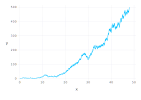

In [136]:
Gadfly.plot(x=tvec, y=Nvec, Geom.step)

In [150]:
sum(fitnessVec)

0

In [148]:
detLim = 0
detmuts = []
detneoep_muts = []
for mutID in muts
    if sum(mutVec.==mutID) > detLim
        push!(detmuts, mutID)
        if mutID in neoep_muts
            push!(detneoep_muts, mutID)
        end
    end
end

In [149]:
length(detneoep_muts)/length(detmuts)

0.7928546891102713

Input parameters: 
	 Mutation rate: 10.00
	 Death rate of host population: 0.00
	 Effective mutation rate (μ/β): 10.00
	 Number of clonal mutation: 200
	 Number of subclones: 1

Subclone 1 
	Frequency: 0.55
	Number of mutations in subclone: 121
	Fitness advantage: 8.20
	Time subclone emerges (population doublings): 7.92
	Number of divisions: 13
	Average number of divisions per cell: 11.08
	Population size when subclone emerges: 242
	Parent of subclone (0 is host): 0


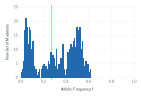

In [8]:
simdata = simulate(0.4, 0.6, μ = 10.0, clonalmutations = 200)
#print summary
show(simdata)

#plot histogram
vafhistogram(simdata, annotateclones = true)

In [32]:
rand()<0.8

true